# Load packages

In [1]:
using JudiLing
using CSV # read csv files into dataframes
using DataFrames # parse data into dataframes
using Plots, StatsPlots # to look at some of the measures

using JudiLingMeasures

# Setup
Use standard latin example, explanations are [here](https://github.com/MegamindHenry/JudiLing.jl).

In [2]:
# Comment this in if you haven't downloaded the latin datasets already
#download("https://osf.io/2ejfu/download", joinpath(@__DIR__, "latin_train.csv"))
#download("https://osf.io/bm7y6/download", joinpath(@__DIR__,"latin_val.csv"))

latin_train =
    DataFrame(CSV.File(joinpath(@__DIR__, "latin_train.csv")))
latin_val =
    DataFrame(CSV.File(joinpath(@__DIR__, "latin_val.csv")))

cue_obj_train, cue_obj_val = JudiLing.make_cue_matrix(
    latin_train,
    latin_val,
    grams = 3,
    target_col = :Word,
    tokenized = false,
    keep_sep = false
)

n_features = size(cue_obj_train.C, 2)
S_train, S_val = JudiLing.make_S_matrix(
    latin_train,
    latin_val,
    ["Lexeme"],
    ["Person", "Number", "Tense", "Voice", "Mood"],
    ncol = n_features
)

G_train = JudiLing.make_transform_matrix(S_train, cue_obj_train.C)
F_train = JudiLing.make_transform_matrix(cue_obj_train.C, S_train)

Chat_train = S_train * G_train
Chat_val = S_val * G_train
Shat_train = cue_obj_train.C * F_train
Shat_val = cue_obj_val.C * F_train

A = cue_obj_train.A
max_t = JudiLing.cal_max_timestep(latin_train, latin_val, :Word)

res_learn_train, gpi_learn_train, rpi_learn_train = JudiLingMeasures.learn_paths_rpi(
    latin_train,
    latin_train,
    cue_obj_train.C,
    S_train,
    F_train,
    Chat_train,
    A,
    cue_obj_train.i2f,
    cue_obj_train.f2i, # api changed in 0.3.1
    gold_ind = cue_obj_train.gold_ind,
    Shat_val = Shat_train,
    check_gold_path = true,
    max_t = max_t,
    max_can = 10,
    grams = 3,
    threshold = 0.05,
    tokenized = false,
    sep_token = "_",
    keep_sep = false,
    target_col = :Word,
    issparse = :dense,
    verbose = false,
);

res_learn_val, gpi_learn_val, rpi_learn_val = JudiLingMeasures.learn_paths_rpi(
    latin_train,
    latin_val,
    cue_obj_train.C,
    S_val,
    F_train,
    Chat_val,
    A,
    cue_obj_train.i2f,
    cue_obj_train.f2i, # api changed in 0.3.1
    gold_ind = cue_obj_val.gold_ind,
    Shat_val = Shat_val,
    check_gold_path = true,
    max_t = max_t,
    max_can = 10,
    grams = 3,
    threshold = 0.05,
    is_tolerant = true,
    tolerance = -0.1,
    max_tolerance = 2,
    tokenized = false,
    sep_token = "-",
    keep_sep = false,
    target_col = :Word,
    issparse = :dense,
    verbose = false,
);


# General help with measures

Each measure comes with a documentation, which you can call via

In [3]:
?JudiLingMeasures.L1Norm

```
L1Norm(M::Union{JudiLing.SparseMatrixCSC, Matrix})
```

Compute the L1 Norm of each row of a matrix.

# Examples

```jldoctest
julia> Shat = [[1 2 3]; [-1 -2 -3]; [1 2 3]]
julia> L1Norm(Shat)
3-element Vector{Int64}:
 6
 6
 6
```


# Computing measures

## Computing all available measures

JudiLingMeasures has an implemented function which returns all currently available measures for the data of interest. This can be called simply by

In [4]:
dat_all_measures = JudiLingMeasures.compute_all_measures(latin_val, # the data of interest
                                                         cue_obj_train, # the cue_obj of the training data
                                                         cue_obj_val, # the cue_obj of the data of interest
                                                         Chat_val, # the Chat of the data of interest
                                                         S_val, # the S matrix of the data of interest
                                                         Shat_val, # the Shat matrix of the data of interest
                                                         res_learn_val, # the output of learn_paths for the data of interest
                                                         gpi_learn_val, # the gpi_learn object of the data of interest
                                                         rpi_learn_val); # the rpi_learn object of the data of interest

Recognition not implemented


The resulting dataframe includes all the measures:

In [5]:
dat_all_measures[1:10, [2:3;19:end]]

,Word,Lexeme,PathSum,TargetPathSum,PathSumChat,C-Precision,L1Chat
,String,String,Float64,Float64,Any,Float64,Float64
1,doceebitur,docere,3.7036,3.7036,4.65773,0.565497,23.7994
2,audieebaas,audire,4.59556,4.94948,4.66293,0.559771,24.4365
3,cuccurerint,currere,3.96154,3.96154,4.94808,0.587485,22.4387
4,carpereetis,carpere,4.18955,4.18955,4.85837,0.510669,25.6224
5,carpiaamus,carpere,4.19961,4.19961,5.32665,0.633173,23.6295
6,carpeebant,carpere,4.77745,4.77745,5.13405,0.558818,25.8623
7,carpiaamur,carpere,3.81647,3.81647,4.85789,0.558479,24.835
8,terreeret,terrere,4.58405,4.46162,4.61507,0.626944,25.8132
9,vocaavit,vocare,4.24587,3.62604,4.79271,0.547825,23.0664


Some visualisation of the resulting measures:

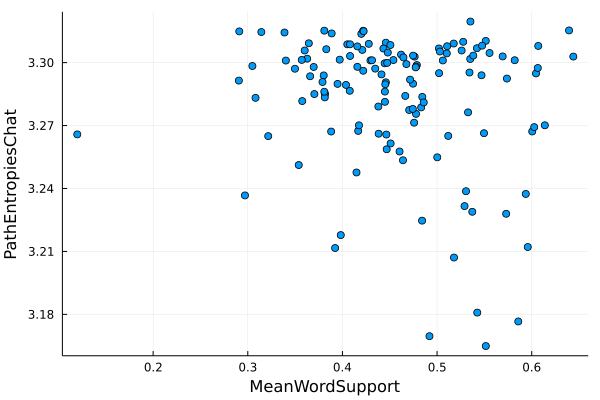

In [6]:
plot(dat_all_measures.MeanWordSupport, 
     dat_all_measures.PathEntropiesChat, seriestype=:scatter, label=false,
     xlab="MeanWordSupport", ylab="PathEntropiesChat")

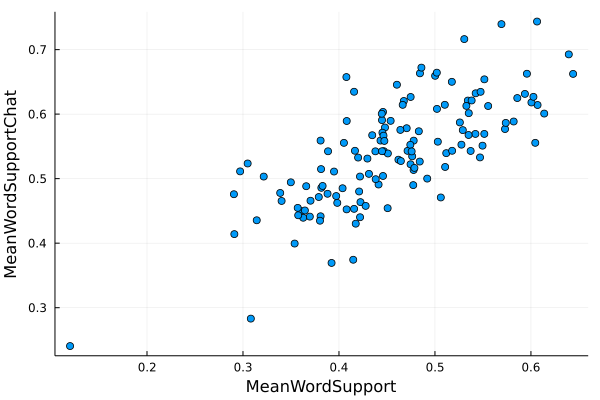

In [7]:
plot(dat_all_measures.MeanWordSupport, 
     dat_all_measures.MeanWordSupportChat, seriestype=:scatter, label=false,
     xlab="MeanWordSupport", ylab="MeanWordSupportChat")

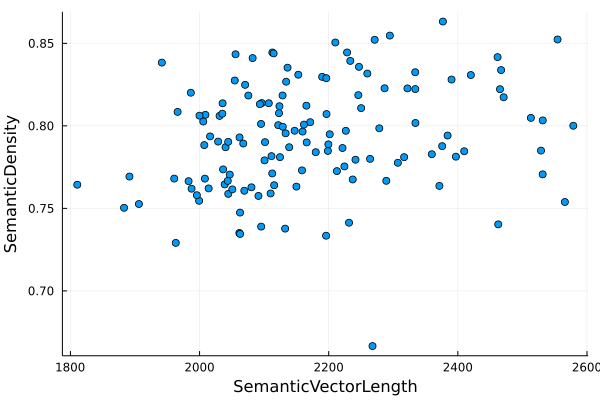

In [8]:
plot(dat_all_measures.L1Shat, 
     dat_all_measures.SemanticDensity, seriestype=:scatter, label=false,
     xlab="SemanticVectorLength", ylab="SemanticDensity")

## Computing a custom set of measures

In the following, we implement a function which computes a few of the available measures, for demonstration purposes. Let's say we are interested primarily in measures of comprehension and production **accuracy**. We might settle on the following functions (as an example, please also consider other measures of you are interested in mapping accuracy):

- TargetCorrelation
- rank
- SCPP
- C-Precision
- PathEntropiesChat

We therefore define the following function:

In [9]:
function compute_accuracy_measures(data_val::DataFrame,
                                  cue_obj_train::JudiLing.Cue_Matrix_Struct,
                                  cue_obj_val::JudiLing.Cue_Matrix_Struct,
                                  Chat_val::Union{JudiLing.SparseMatrixCSC, Matrix},
                                  S_val::Union{JudiLing.SparseMatrixCSC, Matrix},
                                  Shat_val::Union{JudiLing.SparseMatrixCSC, Matrix},
                                  res_learn::Array{Array{JudiLing.Result_Path_Info_Struct,1},1},
                                  gpi_learn::Array{JudiLing.Gold_Path_Info_Struct,1},
                                  rpi_learn::Array{JudiLing.Gold_Path_Info_Struct,1})
    # MAKE PREPARATIONS

    # generate additional objects for the measures such as
    # - results: copy of data_val for storing the measures in
    # - cor_s: the correlation matrix between Shat and S
    # - df: DataFrame of res_learn, the output of learn_paths
    # - pred_df: DataFrame with path supports for the predicted forms produced by learn_paths
    results, cor_s, df, pred_df = JudiLingMeasures.make_measure_preparations(data_val, S_val, Shat_val,
                                    res_learn, cue_obj_train, cue_obj_val, rpi_learn)


    # CALCULATE MEASURES

    # comprehension accuracy
    results[!,"TargetCorrelation"] = JudiLingMeasures.target_correlation(cor_s)
    results[!,"rank"] = JudiLingMeasures.rank(cor_s)

    # production accuracy
    results[!,"SCPP"] = JudiLingMeasures.SCPP(df, results)
    results[!,"C-Precision"] = JudiLingMeasures.c_precision(Chat_val, cue_obj_val.C)
    results[!,"PathEntropiesChat"] = JudiLingMeasures.path_entropies_chat(res_learn, Chat_val)


    results
end

compute_accuracy_measures (generic function with 1 method)

Now we can call this function.

In [10]:
dat_accuracy_measures = compute_accuracy_measures(latin_val, # the data of interest
                                                 cue_obj_train, # the cue_obj of the training data
                                                 cue_obj_val, # the cue_obj of the data of interest
                                                 Chat_val, # the Chat of the data of interest
                                                 S_val, # the S matrix of the data of interest
                                                 Shat_val, # the Shat matrix of the data of interest
                                                 res_learn_val, # the output of learn_paths for the data of interest
                                                 gpi_learn_val, # the gpi_learn object of the data of interest
                                                 rpi_learn_val); # the rpi_learn object of the data of interest

In [11]:
first(dat_accuracy_measures, 10)

,Column1,Word,Lexeme,Person,Number,Tense,Voice,Mood,TargetCorrelation
,Int64,String,String,String,String,String,String,String,Float64
1,309,doceebitur,docere,p3,sg,future,passive,ind,0.99509
2,62,audieebaas,audire,p2,sg,past,active,ind,0.990535
3,576,cuccurerint,currere,p3,pl,perfect,active,subj,0.994793
4,473,carpereetis,carpere,p2,pl,past,active,subj,0.994436
5,376,carpiaamus,carpere,p1,pl,present,active,subj,0.992941
6,90,carpeebant,carpere,p3,pl,past,active,ind,0.992004
7,424,carpiaamur,carpere,p1,pl,present,passive,subj,0.992304
8,447,terreeret,terrere,p3,sg,past,active,subj,0.992967
9,147,vocaavit,vocare,p3,sg,perfect,active,ind,0.995215
